# Bayesian Parameter Estimation

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
# Library to perform MCMC runs
import emcee

import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}

pboc_rc = { ##########SIZES################## 
                'lines.linewidth'       : 2, 
                'axes.titlesize'        : 18,
                'axes.labelsize'        : 16,
                'font.family'           : 'Lucida Sans Unicode',
                
                ##########COLORS#################
                'axes.facecolor'        :'#E3DCD0',
                
                #########GRIDS/TICKS############
                'xtick.labelsize'       : 12,
                'ytick.labelsize'       : 12,

                #########LEGEND#################
                'legend.numpoints'      : 1,
                'legend.fontsize'       : 13,
                'legend.loc'            : 'best',
                }
 
#Define the colorscheme. 
# r, b, m, g, orange
pboc  = sns.color_palette(['#d46c55', '#7aa874','#728ec1',
                           '#aa85ab','#e08d14']) 

sns.set_context('notebook', rc=pboc_rc)
sns.set_style('dark', rc=pboc_rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

The fold-change in gene expression due to the presence of the transcriptional repressor for our simple repression architecture is given by

\begin{equation}
    \text{fold-change} = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific binding sites, $\Delta \epsilon_{ai}$ is the energy diference between the active and inactive state of the repressor, $\Delta \epsilon_r$ is the repressor binding energy to the DNA, and $p_{act}(C)$, the probability of the repressor being in the active state as a function of the ligand concentration $C$ is given by

\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience. $K_A$ and $K_I$ are the dissociation constants of the ligand in the active and inactive state respectively.

In this notebook we will perform a parameter estimation using MCMC for the different set of repressor mutants. Recall that we generated single point mutations in two different locations of the repressor. If the previous equation is to be taken seriously we should be able to distinguish which parameter should change depending on the part of the protein where the mutation was generated. The two types of mutations and their corresponding parameters are
1. **DNA binding domain mutations** with a corresponding change in the $\Delta \epsilon_r$ parameter.
2. **Inducer binding domain mutations** with a corresponding change in the dissociation constants $K_A$ and $K_I$

The fitting procedure is the exact same for both cases. The only difference is which parameters are allowed to vary and which are taken as constants.

As a concrete example let's assume that we have an **inducer binding domain mutant** and we want to fit the parameters $\epsilon_A$ and $\epsilon_I$. By Bayes theorem we have that

\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, I) \cdot P(\epsilon_A, \epsilon_I \mid I),
\end{equation}

where $D$ is the experimental data and $I$ is all the previous information.

The simplest statistical model would consist on the following asusmptions:
1. each measurement is independent
2. the errors are Gaussian distributed
3. the error distribution is homoscedastic, i.e. this error is constant along the range of inducer concentrations.

It is important to indicate that each element of $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$) and the independent variables (the repressor copy number $R$, the binding energy $\Delta \epsilon_r$ and the inducer concentration $C$). With this in hand we implement the first assumption refering to the independence of measurements as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\end{equation}

where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the priors we can assume that the 3 parameters $\epsilon_A, \epsilon_I$ and $\sigma$ are not only independent, but since they have a uniform prior in log scale they can have a Jeffres' prior, i.e.

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid I) \equiv \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid D, I) \propto \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right] \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

For the **DNA binding domain mutants** the only differences is that the independent varaibles in the data $D$ contain the variables $\epsilon_A$ and $\epsilon_I$ instead of the repressor binding energy.

Since the parameter we would like to fit $\Delta \epsilon_r$ also has a uniform distribution in log scale, we can assign to it a Jeffreys' prior to it getting at the end a posterior of the form

\begin{equation}
P(\Delta \epsilon_r, \sigma \mid D, I) \propto \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\Delta\epsilon_r, \epsilon_A^{(i)}, \epsilon_I^{(i)}, R^{(i)}, C^{(i)} \right) \right)^2 \right] \frac{1}{\Delta \epsilon_r}\cdot\frac{1}{\sigma}
\end{equation}

### The MCMC approach to the problem.

Before when we tackled this problem analytically we had to integrate out the nuance parameter $\sigma$ out of the distribution. but now since we will be using MCMC all we have to do is to define the log probability $\ln P(\epsilon_A, \epsilon_I, \sigma \mid D, I)$ and let the computer do the nasty integration for us.

The big advantage of this approach is that it relegates the heavy math required to perform these integrations, and allows the computer to solve the problem numerically for us. This will be very handy once we start to relax some of the assumptions in the model.

As for now let's define the log probability distribution!

In [2]:
def log_likelihood(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var, epsilon=4.5,
             ea_range=[6 -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, sigma = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var, epsilon)

## Running the MCMC on the data 
Now that we defined our functions, let's test it on the experimental data we have gathered so far.

In [2]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O2_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

Number of unique data-sets: 11


date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160804  mrazomej       O2           -13.9    RBS1L         870      0.0   
3  20160804  mrazomej       O2           -13.9     RBS1         610      0.0   
4  20160804  mrazomej       O2           -13.9  RBS1027         130      0.0   
5  20160804  mrazomej       O2           -13.9   RBS446          62      0.0   
6  20160804  mrazomej       O2           -13.9  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3624.474605         111.851286       0.007146  
3  3619.786265         107.162946       0.006847  
4  3717.019527         204.396208       0.013059  
5  3854.650585         342.027265       0.021853  
6  4169.802851         657.179531       0.041988

The log posterior takes as arguments the parameters, and a series of independent and dependent variables. The independent variables are the IPTG concentration, the repressor copy number and the binding energy of the repressor to the operator.

Let's extract those features from the data for only one strain.

In [4]:
rbs = df[df.rbs=='RBS1027']
# extracting independent and dependent variables
indep_var = rbs[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df[df.rbs=='RBS1027'].fold_change_A

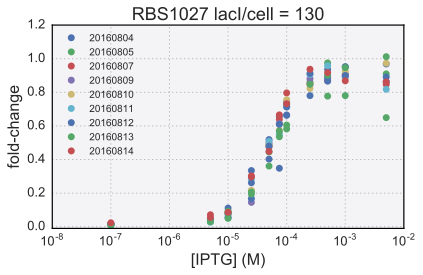

In [12]:
plt.figure()
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG_uM / 1E6,
             rbs[rbs.date==date].fold_change_A, 'o',
            label=str(date), alpha=0.7)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.xlim([1E-8, 1E-2])
plt.ylim([-0.01, 1.2])
plt.legend(loc='upper left')
plt.title('RBS1027 lacI/cell = 130')
plt.tight_layout()

Now let's define all the necessary stuff to run the MCMC.

To initialize the walkeres we will "cheat", meaning that we will use the non-linear regression approach to find the MAP and then initialize the walkers within that region using `numpy`'s `multivariate_normal` sampler.

In [10]:
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(rbs, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

In [11]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

Let's instanciate the sampler

In [12]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

Perform the burn-in steps.

In [13]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Once we do the burn-in steps let's now run the real MCMC routine!

For convenience we will pickle the sampler such that we can load the MCMC results without having to re-run the code.

In [14]:
sample = True
if sample:
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_gauss_homoscedastic_RBS1027.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

Let's visualize the results!

### Gaussian likelihood, homoscedastic error

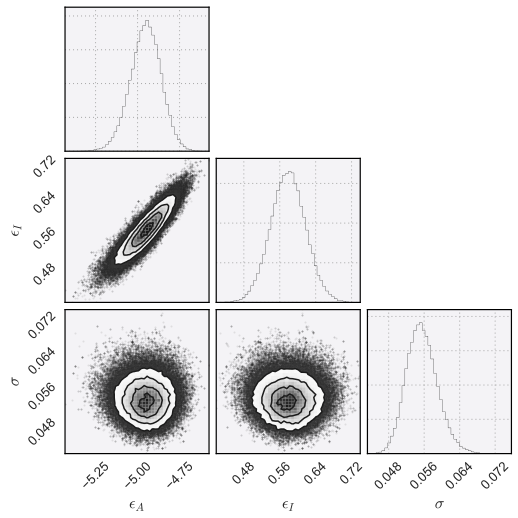

In [5]:
# Load the flat-chain
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

### Reporting the results.

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain.

In [3]:
# Load the flat-chain
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(gauss_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 141.52 +28.640 -23.106 uM
Ki = 0.56061 +0.045490 -0.041155 uM



Let's see how these parameters predict the rest of the strains.

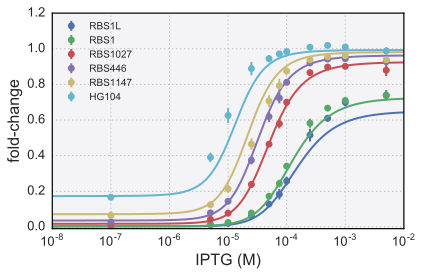

In [4]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

# Plotting the credible region using the MCMC traces.

Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals.

Think about it in the following way: The MCMC walkers explore the parameter space in a way proportional to the probability of each of the parameteres, so if we were to compute the fold change for each and every step this would be done proportionally to how probable each fold-change value is, taking into account all the possible complicated non-linear relationships between parameters.

It might be computationally more expensive, but this way guarantees that the credible regions are drawn according to the proper posterior probability of the parameters.

Let's define a function that takes the `emcee` `flatchains` and computes the confidence interval.

In [5]:
def mcmc_cred_region(IPTG, flatchain, R, epsilon_r,
                     mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameteres.
        flatchain[:,0] = ea flat-chain
        flatchain[:,1] = ei flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

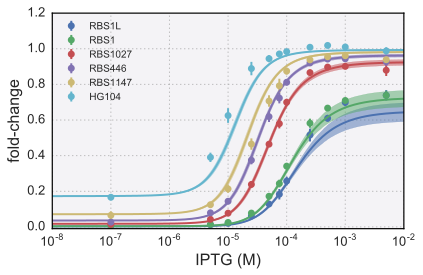

In [6]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_flatchain, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9)
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

## Testing the O2 RBS1027 fit on the O1 data

In [9]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O1_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df_O1 = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df_O1 = df_O1[(df_O1.rbs != 'auto') & (df_O1.rbs != 'delta')]

df_O1.head()

Number of unique data-sets: 2


date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160819  nbellive       O1           -15.3    RBS1L         870      0.0   
3  20160819  nbellive       O1           -15.3     RBS1         610      0.0   
4  20160819  nbellive       O1           -15.3  RBS1027         130      0.0   
5  20160819  nbellive       O1           -15.3   RBS446          62      0.0   
6  20160819  nbellive       O1           -15.3  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3284.654178          47.038532       0.004017  
3  3175.688465         -61.927181      -0.005289  
4  3278.432719          40.817073       0.003486  
5  3237.250759          -0.364887      -0.000031  
6  3335.884241          98.268595       0.008393

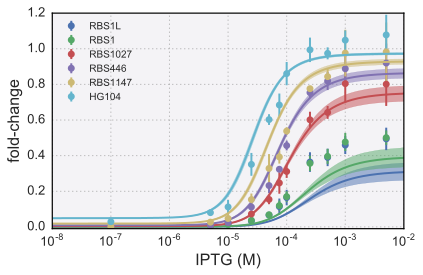

In [10]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df_O1[df_O1.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

### Running the MCMC with all the data except wild-type

Now it's time to run the MCMC using all of the strains but wild-type simultaneously.

In [18]:
# extracting independent and dependent variables
indep_var = df[df.rbs!='HG104'][['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df[df.rbs!='HG104'].fold_change_A

# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

In [19]:
# Set the ranges for the MCMC
ea_range = [-7, 7]
ei_range = [-7, 7]
sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(indep_var, dep_var, 4.5, ea_range, ei_range, sigma_range),\
                threads=6)

In [20]:
sample = True
if sample:
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_gauss_homoscedastic_pool_data.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

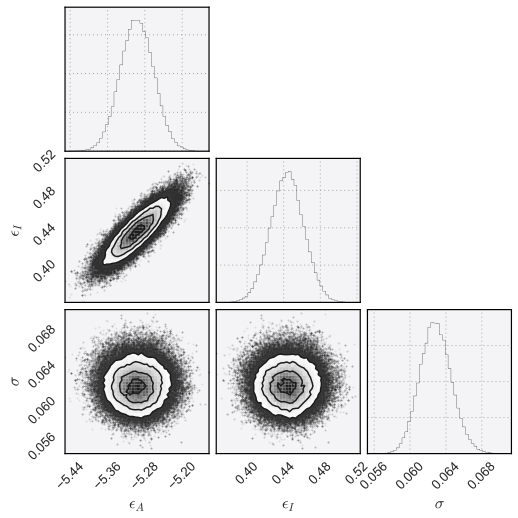

In [16]:
# read the flat-chain
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()

# plot the corner plot
fig = corner.corner(gauss_pool_flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

In [3]:
# Load the data
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 199.71 +14.291 -13.656 uM
Ki = 0.64156 +0.023435 -0.022241 uM



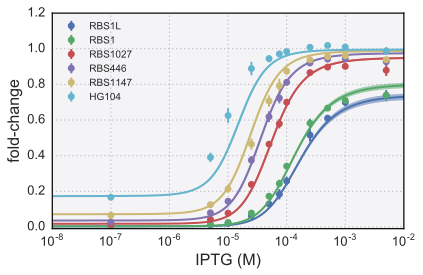

In [6]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9)
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

## Predicting other operators with these parameters.

We will extend these parameters to other operators since in principle once these parameters are fixed there are not unknowns left for the other parameters.

Let's start with O1

In [13]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O1_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df_O1 = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df_O1 = df_O1[(df_O1.rbs != 'auto') & (df_O1.rbs != 'delta')]

df_O1.head()

Number of unique data-sets: 2


date  username operator  binding_energy      rbs  repressors  IPTG_uM  \
2  20160819  nbellive       O1           -15.3    RBS1L         870      0.0   
3  20160819  nbellive       O1           -15.3     RBS1         610      0.0   
4  20160819  nbellive       O1           -15.3  RBS1027         130      0.0   
5  20160819  nbellive       O1           -15.3   RBS446          62      0.0   
6  20160819  nbellive       O1           -15.3  RBS1147          30      0.0   

    mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
2  3284.654178          47.038532       0.004017  
3  3175.688465         -61.927181      -0.005289  
4  3278.432719          40.817073       0.003486  
5  3237.250759          -0.364887      -0.000031  
6  3335.884241          98.268595       0.008393

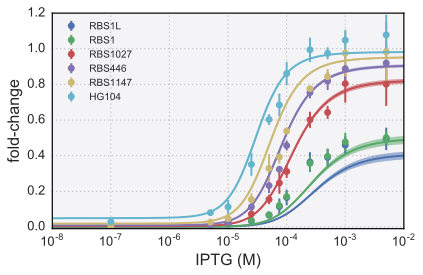

In [14]:
IPTG = np.logspace(-8, -2, 200)
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # compute the mean value for each concentration
    fc_mean = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df_O1[df_O1.rbs==rbs].groupby('IPTG_uM').size())
    
    # plot the experimental data
    plt.errorbar(np.sort(df_O1[df_O1.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err,
        fmt='o', label=rbs, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

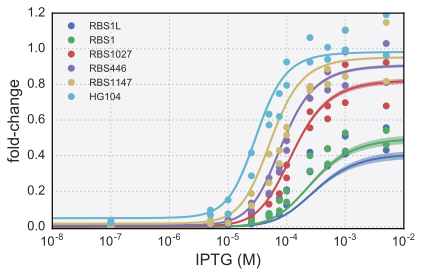

In [16]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df_O1.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1[(df_O1.rbs == rbs)].binding_energy.unique()),
        color=colors[i])
    # plot 95% HPD region using the variability in the MWC parameters
    cred_region = mcmc_cred_region(IPTG * 1E6, 
        gauss_pool_flatchain, epsilon=4.5,
        R=df_O1[(df_O1.rbs == rbs)].repressors.unique(),
        epsilon_r=df_O1.binding_energy.unique())
    plt.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.5, color=colors[i])
    # plot the experimental data
    plt.plot(df_O1[df_O1.rbs == rbs].sort_values(by='IPTG_uM').IPTG_uM / 1E6, 
            df_O1[df_O1.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0, label=rbs, color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

# Second approach:
## Cauchy likelihood (for outliers)

A different approach to the problem is to consider that the residuals, i.e. the difference between our theoretical model and the data, have a Cauchy distribution rather than a Gaussian.

The difference in this approach is that the Cauchy distribution has very long tails compare to the Gaussian distribution. This allows "outliers to exist" but gives them a very small weight when performing the fitting. This is different to what the Gaussian likelihood would do where an outlier is such an incredibly rare event, that every data point that you see must be basically "real" and therefore tries to fit the model giving very similar weight to all the data points.

The assumptions of the model can again be listed as
1. each measurement is independent.
2. the errors are **Cauchy** distributed.
3. the error distribution is homoscedastic, i.e. this error is constant along the range of IPTG.

With this in hand we implement the first assumption as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \beta, I) = \frac{1}{\beta} \prod_{i = 1}^n \left[ \pi \beta \left(1 + \left( \frac{fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right)}{\beta} \right)^2 \right) \right]^{-1}
\end{equation}

where we include the parameter $\beta$ associated with the Cauchy distribution.

We can again assume Jeffrey's priors for all 3 parameters and define again the log-likelihood to perform the MCMC run.

In [ ]:
def log_likelihood_cauchy(param, indep_var, dep_var, epsilon=4.5):
    """
    Computes the Cauchy log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = beta. scale parameter which specifies the half-width 
                   at half-maximum.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the Cauchy log likelihood.
    """
    # unpack parameters
    ea, ei, beta = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r)
   
    log_like = np.sum(np.log(1 + ((fc_theory - dep_var) / beta)**2))
    return log_like

def log_post_cauchy(param, indep_var, dep_var, epsilon=4.5,
                    ea_range=[6 -6], ei_range=[6, -6]):
    '''
    Computes the log posterior probability for a Cauchy likelihood.
    Parameters
    ----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = beta. scale parameter which specifies the half-width 
                   at half-maximum.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    '''
    # unpack parameters
    ea, ei, beta = param
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ea < np.min(ei_range)\
    or beta <= 0:
        return -np.inf
    
    return -(len(indep_var) + 1) * np.log(beta) \
           - log_likelihood_cauchy(param, indep_var, dep_var, epsilon)


Having written the functions let's test them!

In [ ]:
rbs = df[df.rbs=='RBS1027']
# Perform a non-linear regression
map_param =  mwc.non_lin_reg_mwc(rbs, p0=[1, 7], diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[map_param[1], 0], [0, map_param[3]]])

#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 50
n_burn = 500
n_steps = 5000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.exponential(1.0, n_walkers)

In [ ]:
#Call the sampler. 
sampler_cauchy = emcee.EnsembleSampler(n_walkers, n_dim, log_post_cauchy,\
                 args=(indep_var, dep_var, 4.5),\
                 threads=6)

In [ ]:
#Do the burn in 
pos, prob, state = sampler_cauchy.run_mcmc(p0, n_burn, storechain=False)

In [ ]:
# Perform the real MCMC
_ = sampler_cauchy.run_mcmc(pos, n_steps)

### Cauchy likelihood, homoscedastic error

In [ ]:
fig = corner.corner(sampler_cauchy.flatchain, bins=50, plot_contours=True,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\beta$'])